In [1]:
library(ggplot2)

### Problem 1

b)

In [2]:
f_rayleigh = function(x, sigma){
    if (any(x<0)) return (0)
    stopifnot(sigma>0)
    return ((x/sigma^2)*exp(-x^2/(2*sigma^2)))
}

In [3]:
N = 100
sigma = 4
x = numeric(N)
x[1] = rgamma(n=1, shape=1, rate=1)
u = runif(N)
k = 0 

In [4]:
for (i in 2:N){
    xt = x[i-1]
    y = rgamma(n=1, shape=xt, rate=1)
    num = f_rayleigh(y, sigma)*dgamma(xt, y)
    den = f_rayleigh(xt, sigma)*dgamma(y, xt)
    if (u[i] <= num/den){
        x[i] = y
        k = k+1
    }
    else{
        x[i] = xt
    }
}

In [5]:
k/N

[1] 0.69

In [6]:
mh_data = data.frame(index=1:N, x=x)

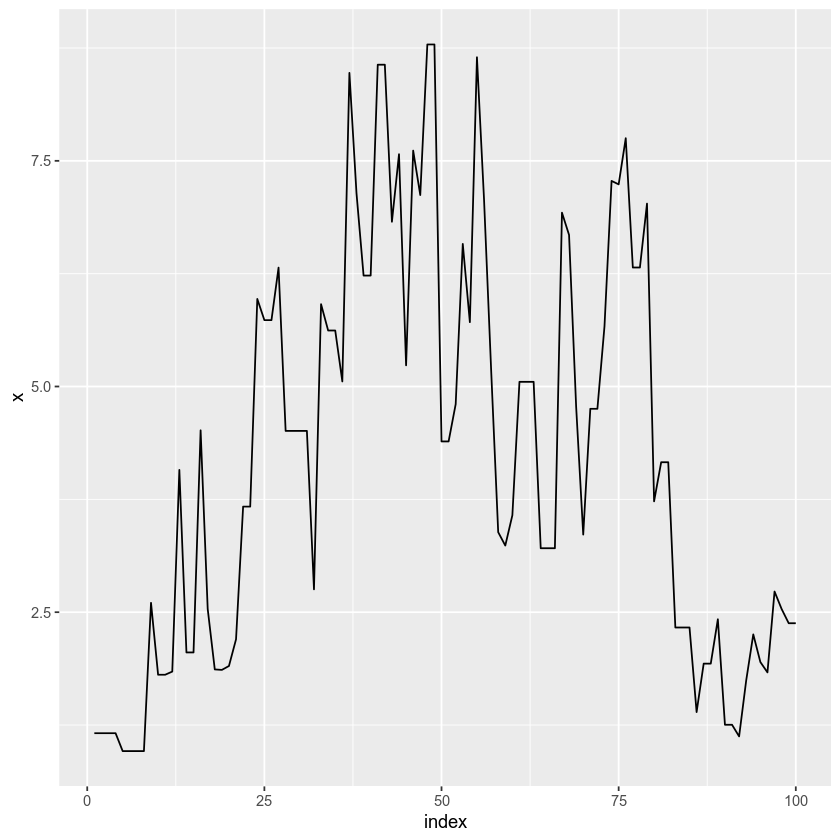

In [7]:
ggplot(mh_data, aes(index, x)) + 
    geom_line()

### Problem 3

### c)

In [43]:
set.seed(197)
N= 10000
p = 0.3
params = c(2, 10)

i = sample(1:2, N, replace = TRUE, prob = c(p, 1-p))
z = rchisq(n = N, params[i])

Warning message:
“Removed 7 rows containing missing values (geom_path).”

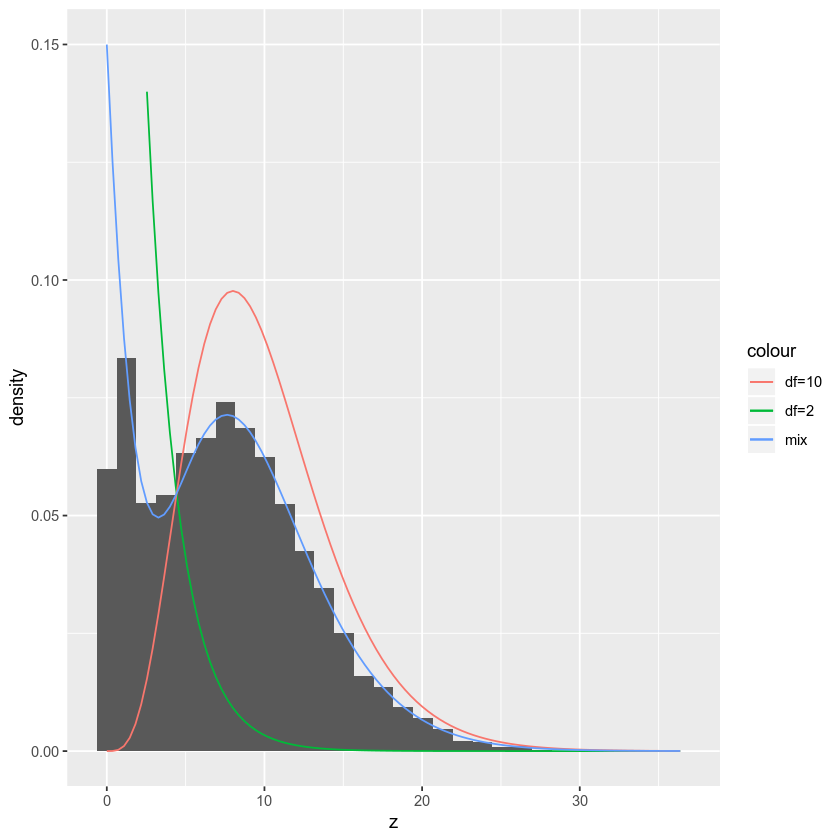

In [44]:
ggplot(data.frame(z), aes(z)) + 
    geom_histogram(aes(y = stat(density)), bins = 30) + 
    stat_function(aes(color = "df=2"), fun = dchisq, args = c(df=2)) + 
    stat_function(aes(color = "df=10"), fun = dchisq, args = c(df=10)) + 
    stat_function(aes(color = "mix"), fun = function(x) p*dchisq(x, 2) + (1 - p)*dchisq(x, 10)) +
    ylim(0, 0.15)

### d)

In [45]:
p = c(0.1, 0.5, 0.9)
k = 0 

In [46]:
func_mixture = function(x, p){
    res = p*dchisq(x = x, df = 2) + (1 - p)*dchisq(x = x, df = 10)
    return (res)
}

In [47]:
indep_sampler = function(z, N, p0){
    p = numeric(N)
    p[1] = p0
    y = runif(n = N, min = 0, max = 1)
    u = runif(n = N, min = 0, max = 1)
    
    for (i in 2:N){
        pt=p[i-1]
        num = func_mixture(z[i], y[i])
        den = func_mixture(z[i], pt)
        
        if (u[i] <= num/den){
            p[i] = y[i]
            k = k + 1
        }
        else
            p[i] = pt
    }
    return (p)
}

In [48]:
indep_sampler_chains = lapply(X = p, FUN = indep_sampler, z = z, N = N)

In [49]:
res_data = data.frame(index = 1:N, 
                      z = unlist(indep_sampler_chains),
                      p = rep(p, each = N))

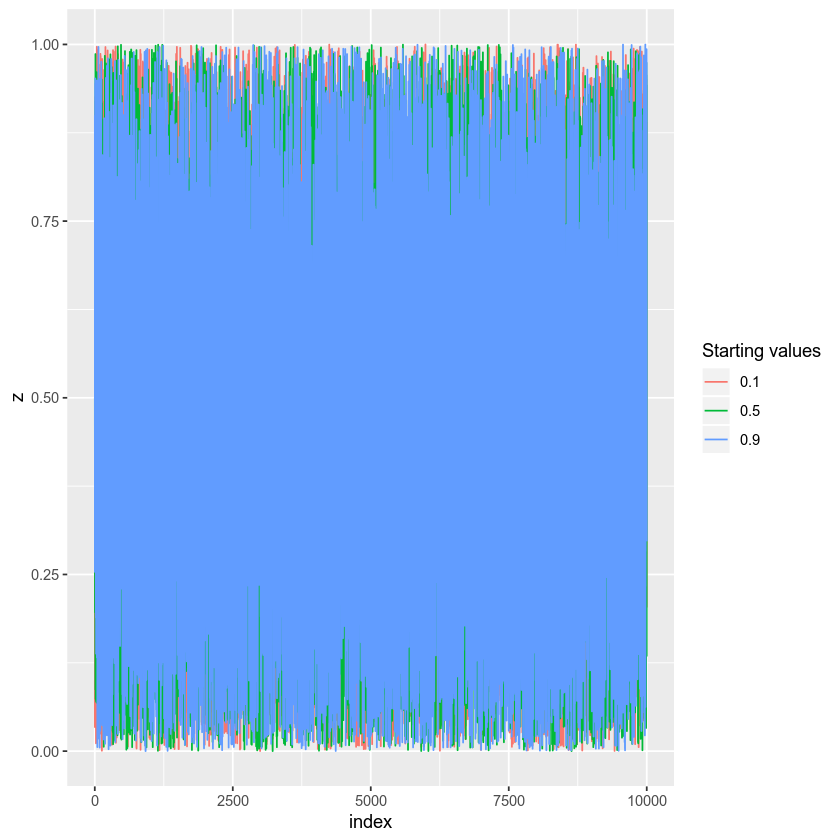

In [50]:
ggplot(res_data, aes(index, z, color=factor(p))) + 
    geom_line() + 
    labs(color = "Starting values")

In [51]:
res_data_burn_in = res_data[res_data$index > 100, ]

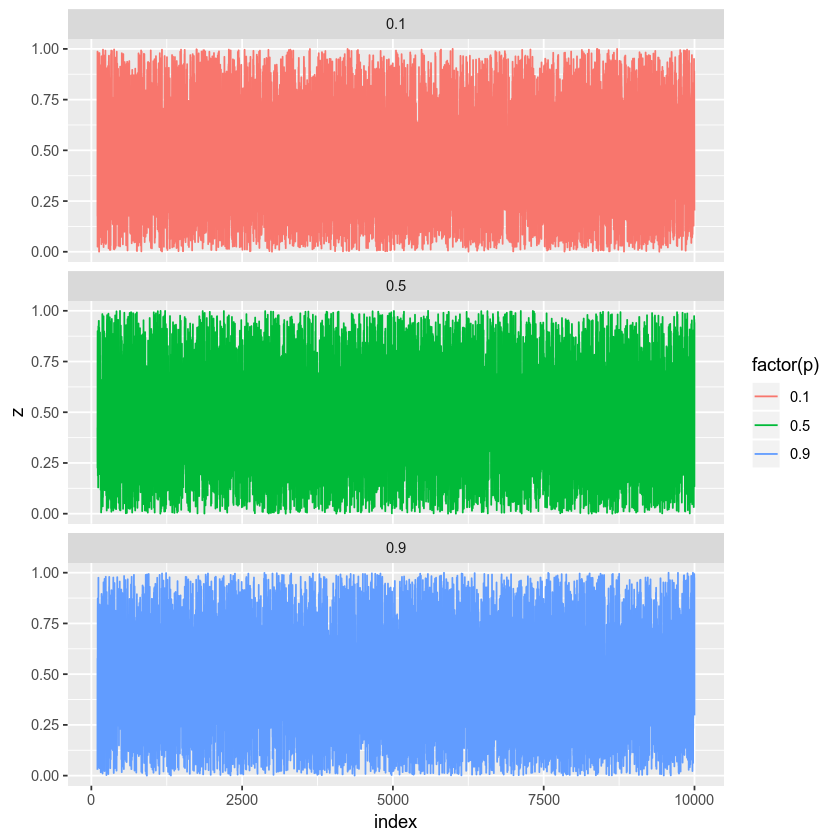

In [52]:
ggplot(res_data_burn_in, aes(index, z, color=factor(p))) +
    geom_line() + 
    facet_wrap(~p, nrow = 3)

In [53]:
aggregate(res_data_burn_in$z, by = list(res_data_burn_in$p), mean)

Group.1,x
<dbl>,<dbl>
0.1,0.4527209
0.5,0.4538538
0.9,0.4540028


### f)

In [72]:
scalar_summary = sapply(indep_sampler_chains, function(x) cumsum(x)/1:N)
scalar_summary = t(scalar_summary)

In [110]:
Gelman.Rubin = function(psi){
    psi = as.matrix(psi)
    n = ncol(psi)
    k = nrow(psi)
    
    row_mean = rowMeans(psi)
    B = n*var(row_mean)
    s_sq = apply(psi, 1, var)
    W = mean(s_sq)
    V_hat = n/(n-1)*W + B/n
    R_hat = V_hat/W
    return (R_hat)
}

In [114]:
Rhat = Gelman.Rubin(scalar_summary)
Rhat

[1] 1.042753

Warning message:
“Removed 1 rows containing missing values (geom_path).”

<ScaleContinuousPosition>
 Range:  
 Limits:    1 --    3

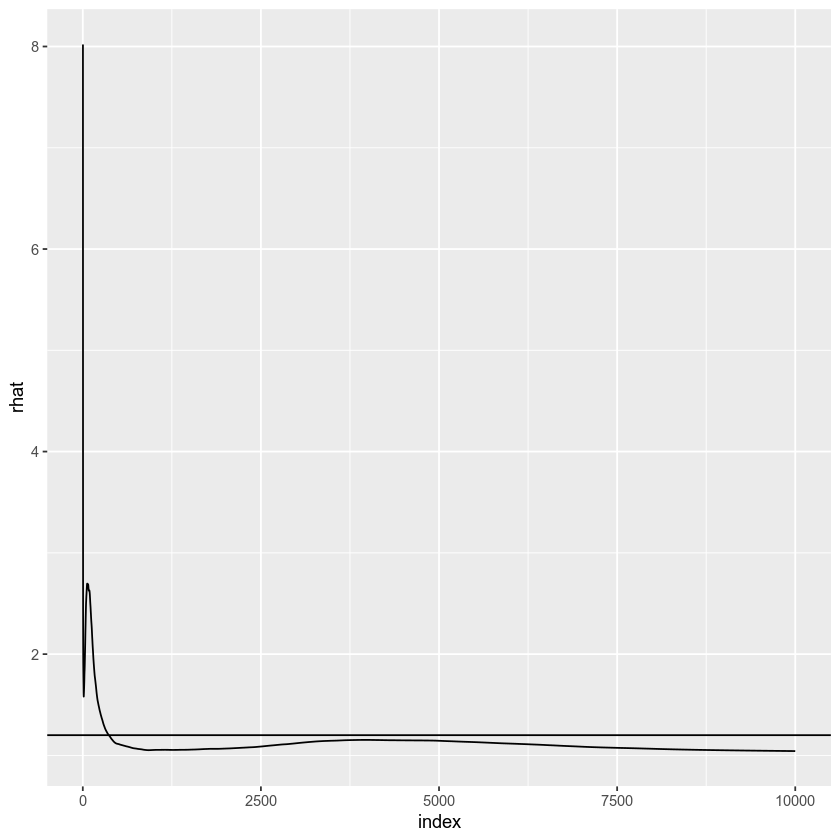

In [115]:
rhat_sequence = sapply(1:N, function(j) Gelman.Rubin(scalar_summary[, 1:j]))
ggplot(data.frame(index = 1:N, rhat = rhat_sequence), aes(index, rhat)) +
    geom_line() +
    geom_hline(yintercept = 1.2)    
    ylim(1, 3)

### Problem 4

### d)

In [124]:
N = 50
burn = 10
rho = 0.5
mu = c(2, 3)
sigma = c(1, 1)
X = matrix(0, N, 2)
s = sapply(1:2, function(i) sqrt(1-rho^2)*sigma[i])

In [127]:
X[1, ] = mu
for (i in 2:N){
    x2 = X[i-1, 2]
    m1 = mu[1] + rho*s[1]/s[2]*(x2-mu[2])
    X[i, 1] = rnorm(1, m1, s[1])
    x1 = X[i, 1]
    m2 = mu[2] + rho*s[2]/s[1]*(x1-mu[1])
    X[i, 2] = rnorm(1, m2, s[2])
}

In [130]:
X[burn:N, ]